In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore
import model

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## 1. PLAN

    a. Acquire, prep and explore data
    b. Build hypothesis
    c. Isolate range in monthly charges where spikes of churn are occuring.
    d. Identify feature most often found in those spikes of churn.
    e. Determine if feature and churn are significantly associated (Chi Square)
    f. Rule out feature being significantly associated with other features (Chi Square)
    g. Fit best models to predict churn based on these features
    h. Extract takeaways:
        - Extent of churn due to isolated features
        - Churn further irritated by what other features
        - Ability to predict churn given which features
    i. Develop recommendations

## 2. ACQUIRE

In [2]:
telco = acquire.get_telco_data()

In [3]:
telco.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


## 3. PREP

In [4]:
telco = prepare.prep_telco(telco)

In [5]:
telco.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,monthly_charges,total_charges,churn,contract_type,DSL,Fiber optic,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,0002-ORFBO,0,0,1,1,9,1,1,0,1,...,65.6,593.30,0,1,1,0,0,0,0,1
1,0003-MKNFE,1,0,0,0,9,1,2,0,0,...,59.9,542.40,0,12,1,0,0,0,0,1
2,0004-TLHLJ,1,0,0,0,4,1,1,0,0,...,73.9,280.85,1,12,0,1,0,0,1,0
3,0011-IGKFF,1,1,1,0,13,1,1,0,1,...,98.0,1237.85,1,12,0,1,0,0,1,0
4,0013-EXCHZ,0,1,1,0,3,1,1,0,0,...,83.9,267.40,1,12,0,1,0,0,0,1


In [6]:
train, val, test = prepare.split_data(telco, 'churn')
train.shape, val.shape, test.shape

((4225, 25), (1409, 25), (1409, 25))

## 4. EXPLORE

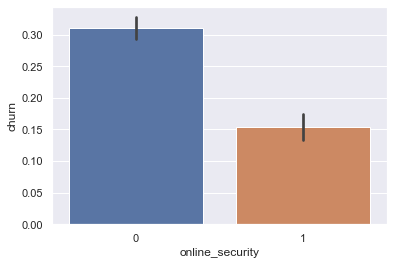

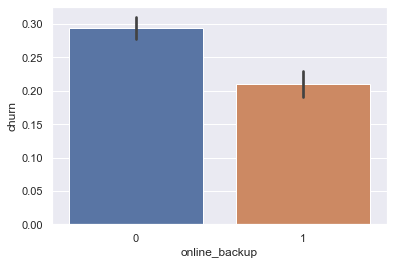

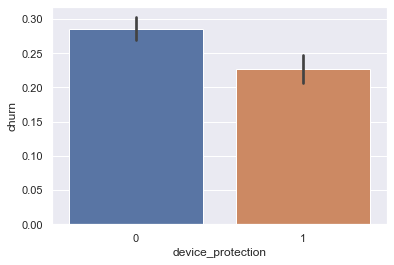

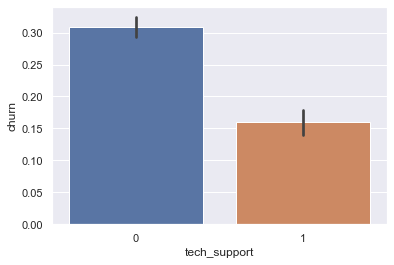

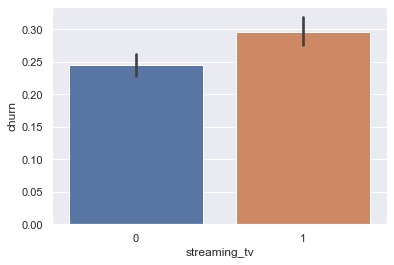

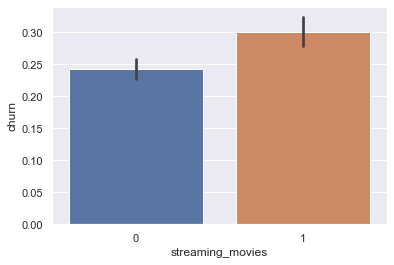

In [7]:
extras = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in extras:
    sns.barplot(data=train, x=col, y='churn')
    plt.show()

Streaming tv and streaming movies churns more often than not. 

All other do not churn more often.

<AxesSubplot:xlabel='streaming_movies', ylabel='streaming_tv'>

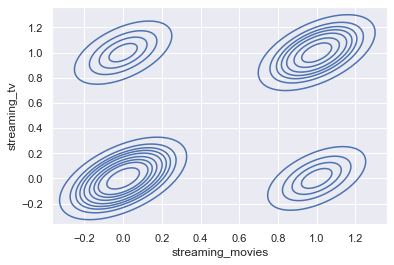

In [8]:
sns.kdeplot(data=train, x='streaming_movies', y='streaming_tv')

In [9]:
pd.crosstab(train.streaming_movies, train.streaming_tv)

streaming_tv,0,1
streaming_movies,,
0,2089,465
1,479,1192


Are there any unused accounts? (No phone line or internet service)

In [10]:
train[(train.DSL == 0) & (train['Fiber optic']==0) & (train.multiple_lines == 0)].shape[0]

0

In [11]:
pd.crosstab(train['Fiber optic'], train.multiple_lines, margins=True)

multiple_lines,0,1,2,All
Fiber optic,,,,
0,393,1348,629,2370
1,0,677,1178,1855
All,393,2025,1807,4225


<AxesSubplot:xlabel='multiple_lines', ylabel='churn'>

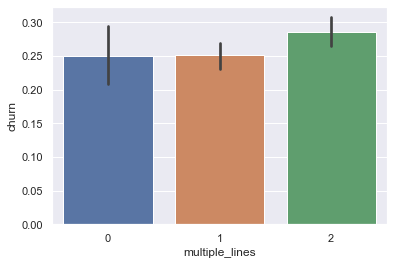

In [12]:
sns.barplot(x=train.multiple_lines, y=train.churn)

In [13]:
train['extras'] = train['online_security'] + train['online_backup']+train['device_protection']+train['tech_support']+ train['streaming_tv']+train['streaming_movies']

In [14]:
nums = ['monthly_charges', 'total_charges']
cats = ['extras','senior_citizen', 'multiple_lines', 'gender', 'partner', 'dependents', 'phone_service','paperless_billing','churn','contract_type','DSL', 'Fiber optic', 'Bank transfer (automatic)','Credit card (automatic)','Electronic check','Mailed check']

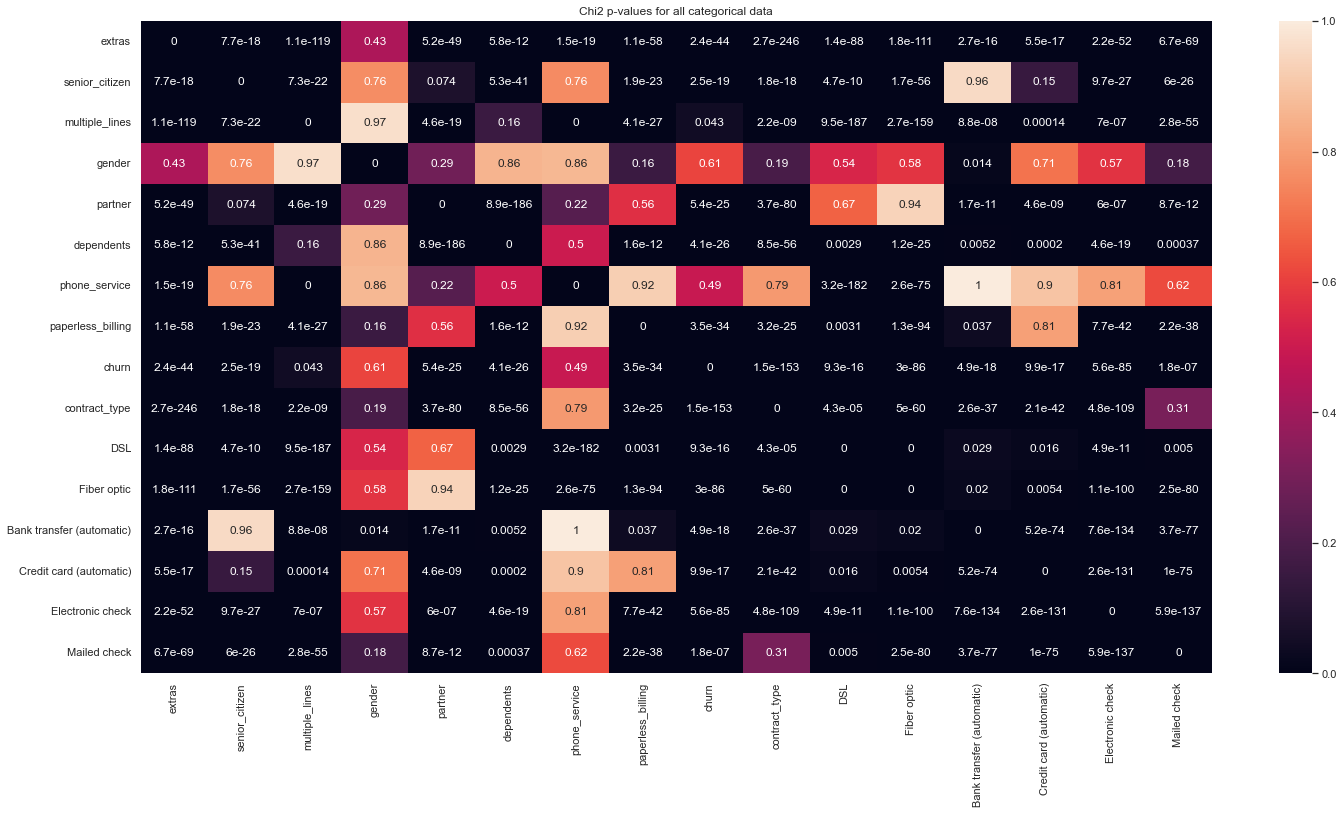

In [15]:
c = []
for col in cats:
    d = []
    for spot in cats:
        alpha = 0.05
        o = pd.crosstab(train[col], train[spot])
        chi2, p, dof, e = stats.chi2_contingency(o)
        d.append(p)
    c.append(d)
c = pd.DataFrame(c)
plt.figure(figsize=(24,12))
sns.heatmap(c, xticklabels=cats, yticklabels=cats, annot=True, fmt='.2g')
plt.title('Chi2 p-values for all categorical data')
plt.show()

extras
0    1316
3     679
2     593
1     577
4     531
5     353
6     176
Name: extras, dtype: int64
0    31.147929
3    16.071006
2    14.035503
1    13.656805
4    12.568047
5     8.355030
6     4.165680
Name: extras, dtype: float64


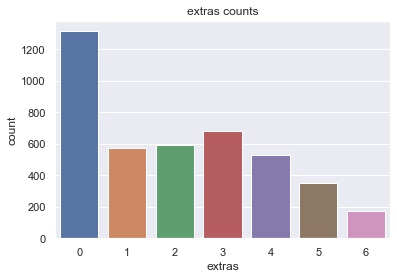

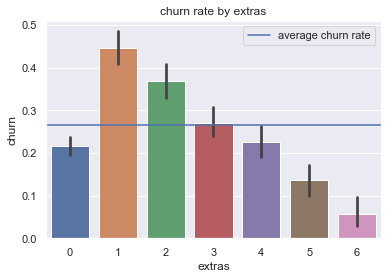

P is less than alpha: True
------------------------------------------------------------
senior_citizen
0    3541
1     684
Name: senior_citizen, dtype: int64
0    83.810651
1    16.189349
Name: senior_citizen, dtype: float64


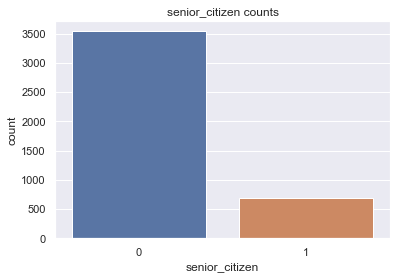

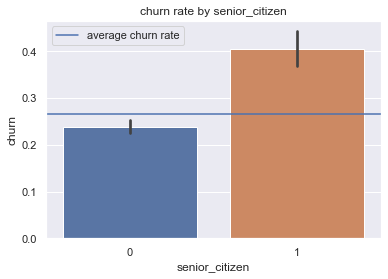

P is less than alpha: True
------------------------------------------------------------
multiple_lines
1    2025
2    1807
0     393
Name: multiple_lines, dtype: int64
1    47.928994
2    42.769231
0     9.301775
Name: multiple_lines, dtype: float64


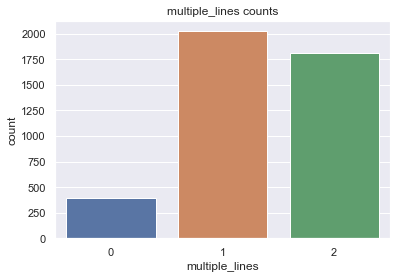

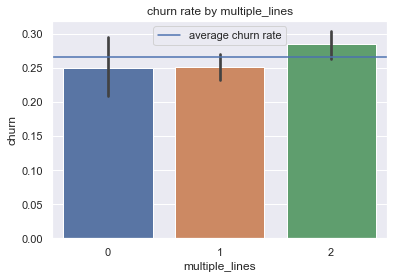

P is less than alpha: True
------------------------------------------------------------
gender
1    2149
0    2076
Name: gender, dtype: int64
1    50.863905
0    49.136095
Name: gender, dtype: float64


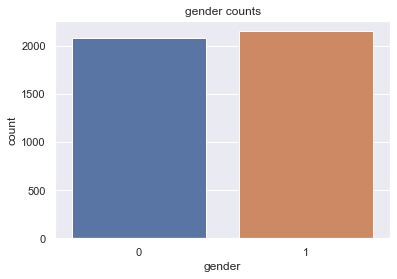

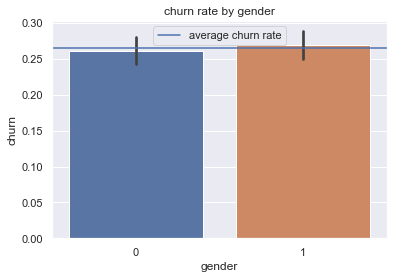

P is less than alpha: False
------------------------------------------------------------
partner
0    2161
1    2064
Name: partner, dtype: int64
0    51.147929
1    48.852071
Name: partner, dtype: float64


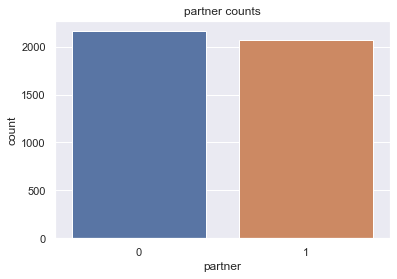

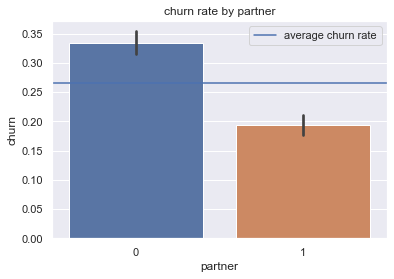

P is less than alpha: True
------------------------------------------------------------
dependents
0    2931
1    1294
Name: dependents, dtype: int64
0    69.372781
1    30.627219
Name: dependents, dtype: float64


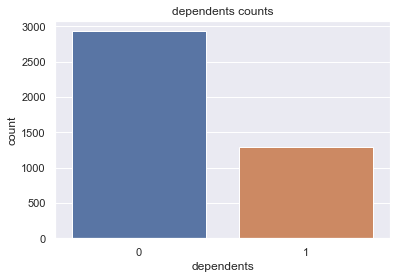

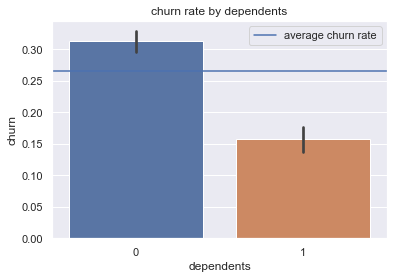

P is less than alpha: True
------------------------------------------------------------
phone_service
1    3832
0     393
Name: phone_service, dtype: int64
1    90.698225
0     9.301775
Name: phone_service, dtype: float64


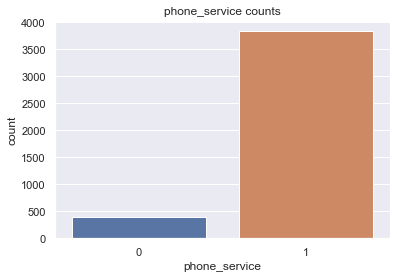

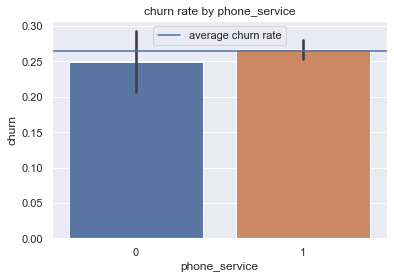

P is less than alpha: False
------------------------------------------------------------
paperless_billing
1    2509
0    1716
Name: paperless_billing, dtype: int64
1    59.384615
0    40.615385
Name: paperless_billing, dtype: float64


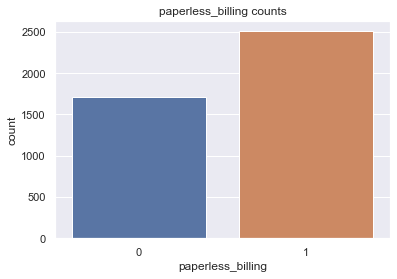

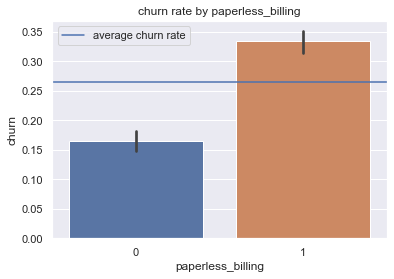

P is less than alpha: True
------------------------------------------------------------
churn
0    3104
1    1121
Name: churn, dtype: int64
0    73.467456
1    26.532544
Name: churn, dtype: float64


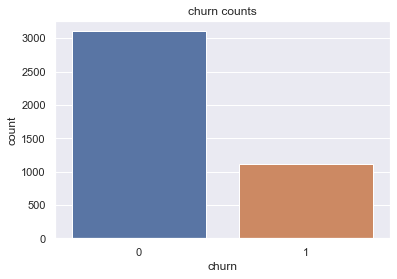

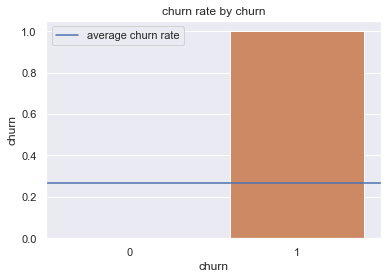

P is less than alpha: True
------------------------------------------------------------
contract_type
12    2317
2      995
1      913
Name: contract_type, dtype: int64
12    54.840237
2     23.550296
1     21.609467
Name: contract_type, dtype: float64


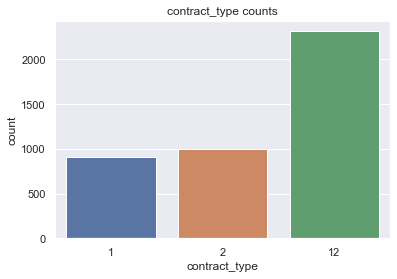

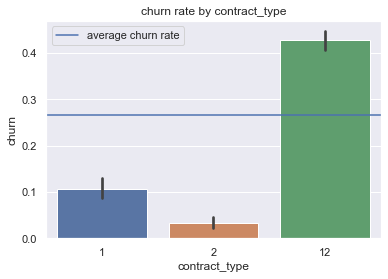

P is less than alpha: True
------------------------------------------------------------
DSL
0    2778
1    1447
Name: DSL, dtype: int64
0    65.751479
1    34.248521
Name: DSL, dtype: float64


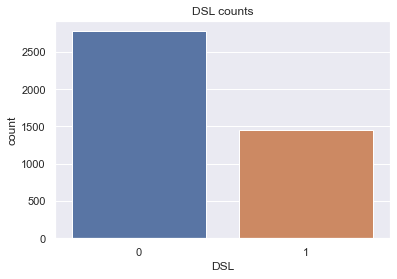

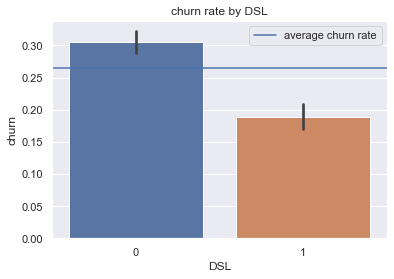

P is less than alpha: True
------------------------------------------------------------
Fiber optic
0    2370
1    1855
Name: Fiber optic, dtype: int64
0    56.094675
1    43.905325
Name: Fiber optic, dtype: float64


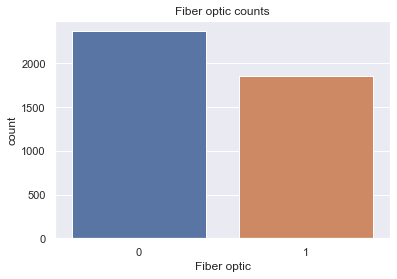

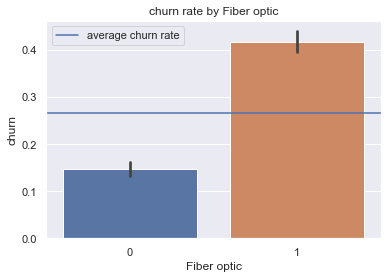

P is less than alpha: True
------------------------------------------------------------
Bank transfer (automatic)
0    3292
1     933
Name: Bank transfer (automatic), dtype: int64
0    77.91716
1    22.08284
Name: Bank transfer (automatic), dtype: float64


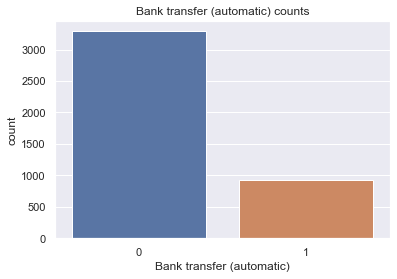

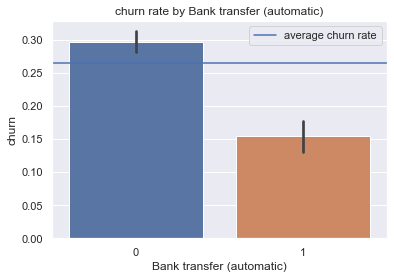

P is less than alpha: True
------------------------------------------------------------
Credit card (automatic)
0    3306
1     919
Name: Credit card (automatic), dtype: int64
0    78.248521
1    21.751479
Name: Credit card (automatic), dtype: float64


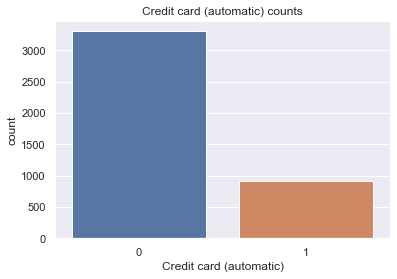

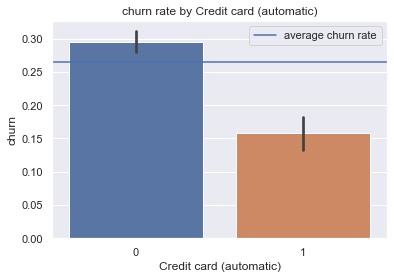

P is less than alpha: True
------------------------------------------------------------
Electronic check
0    2802
1    1423
Name: Electronic check, dtype: int64
0    66.319527
1    33.680473
Name: Electronic check, dtype: float64


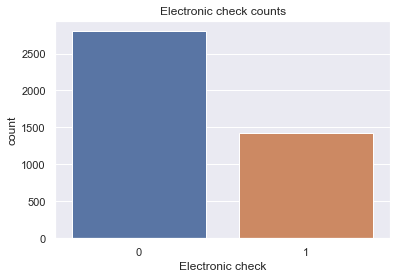

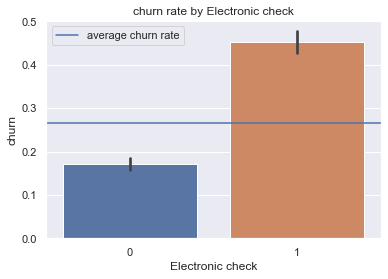

P is less than alpha: True
------------------------------------------------------------
Mailed check
0    3275
1     950
Name: Mailed check, dtype: int64
0    77.514793
1    22.485207
Name: Mailed check, dtype: float64


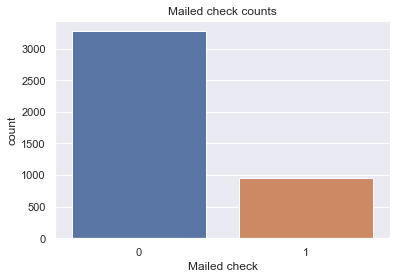

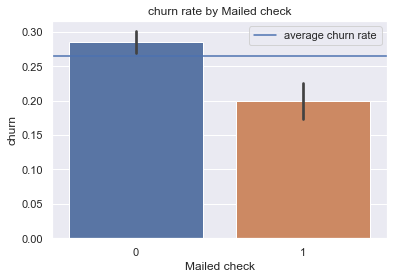

P is less than alpha: True
------------------------------------------------------------


In [16]:
explore.explore_cats(train, cats, 'churn')

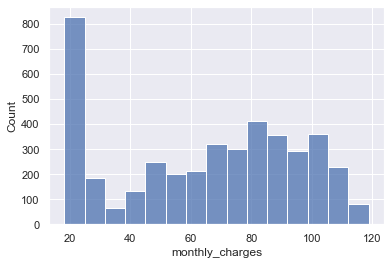

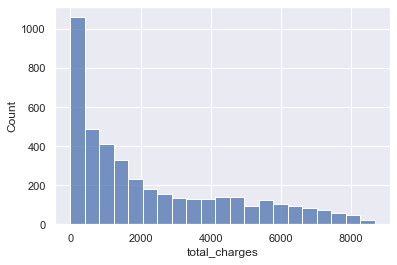

In [17]:
explore.explore_nums(train, nums)

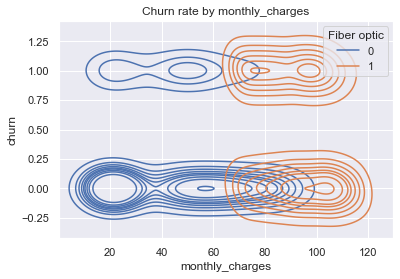

In [18]:
# looking closer at monthly charges and churn
sns.kdeplot(data=train, x='monthly_charges', y='churn', hue='Fiber optic')
rate = train.churn.mean()
plt.title('Churn rate by monthly_charges')
plt.show()

#### INITIAL FINDINGS/QUESTIONS:
1. There is a peak in monthly charges around $80
        Q1. Is a feature causing this cluster?
2. Having more extras, leads to less churn (logic follows they pay more per month OR there is a bundling deal)
        Q2. Does monthly cost go up with additional extras?
3. Having a single line (without dependents or partner) leads to more churn
        Q3. Look into further
4. Having paperless billing leads to almost double the churn than not having paperless billing
        Q4. Possible issue with processing
5. Having fiber optic leads to over double the churn than not having fiber optic
        Q5. What is causing more churn with fiber optic than DSL? DSL seems stable in churn rates.

#### 1. There is a peak in monthly charges around 80
        Q1. Is a feature causing this cluster?
        A1: Fiber optic. Chart above STARTS around 70. DSL can go as low as the 20s

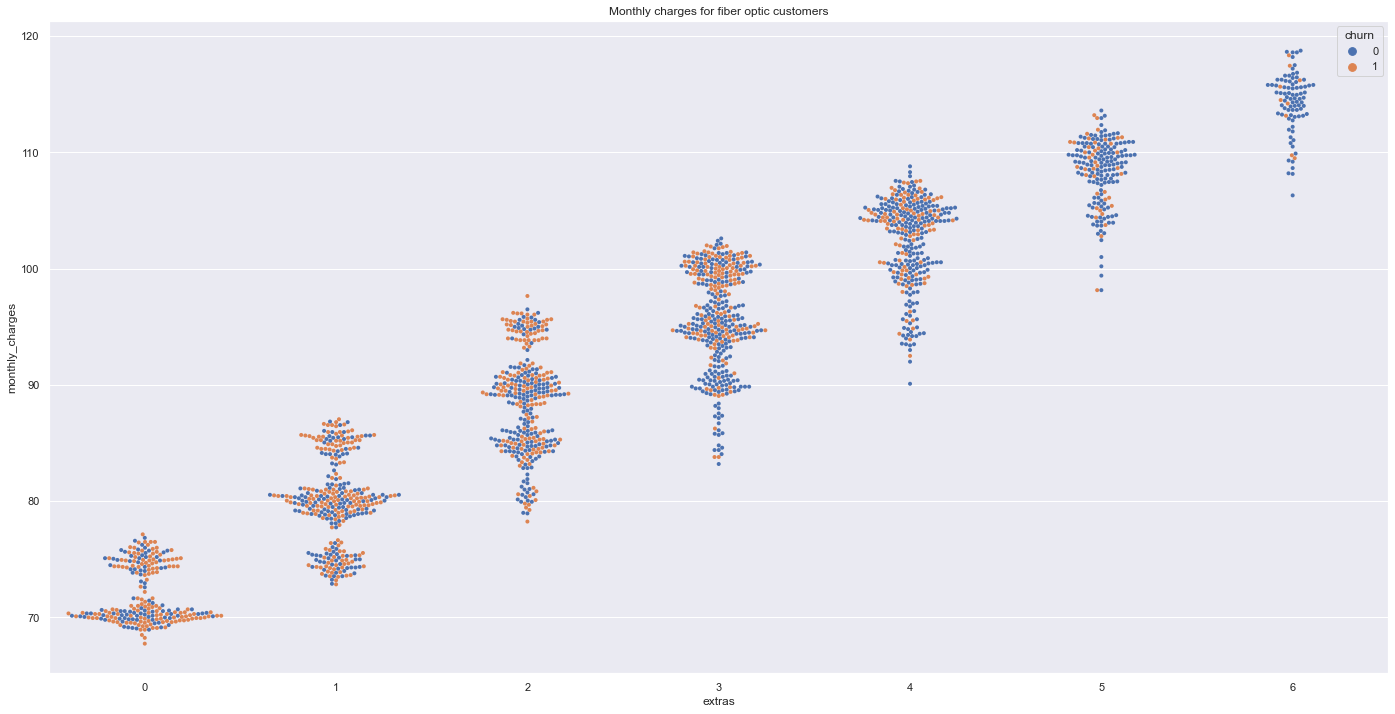

In [19]:
plt.figure(figsize=(24,12))
sns.swarmplot(data=train[train['Fiber optic'] == 1], y='monthly_charges', x='extras', hue='churn', size=4)
plt.title('Monthly charges for fiber optic customers')
plt.show()

In [20]:
train[(train['Fiber optic']==1)&(train.churn == 1)].shape[0]/train[train.churn==1].shape[0]

0.6895628902765388

#### 2. Having more extras, leads to less churn (logic follows they pay more per month OR there is a bundling deal)
        Q2. Does monthly cost go up with additional extras?
        A2. Yes, less churn possibly tied to better consumer experience.

In [21]:
train[['extras','monthly_charges']].groupby('extras').mean()

,monthly_charges
extras,
0,32.595517
1,64.976083
2,72.593086
3,80.062150
4,88.047834
5,92.999575
6,99.336080


<Figure size 1728x864 with 0 Axes>

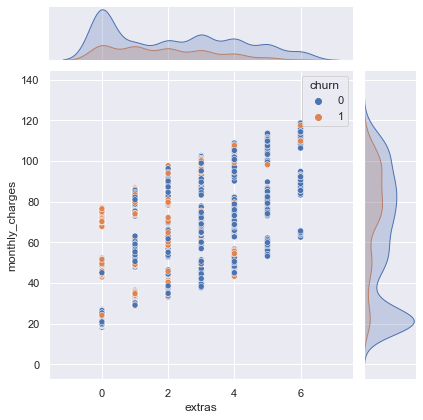

In [22]:
plt.figure(figsize=(24,12))
sns.jointplot(data=train, y='monthly_charges', x='extras', hue='churn', kind='scatter')
plt.show()

#### 4. Having paperless billing leads to almost double the churn than not having paperless billing
        Q4. Specifically how much? Is there another factor tied to this causing it?
        A4. 74.7% of all customers have paperless billing
            19.8% of all customers churned with paperless billing
            25.2% of all churn had paperless billing

In [23]:
train[(train['paperless_billing']==1)&(train.churn == 1)].shape[0]/train.shape[0]

0.1983431952662722

In [24]:
train[(train['paperless_billing']==1)&(train.churn == 1)].shape[0]/train[train.churn==1].shape[0]

0.7475468331846565

#### 5. Having fiber optic leads to over double the churn than not having fiber optic
        Q5. What is causing more churn with fiber optic than DSL? DSL seems stable in churn rates.
        A5. 43.9% of all customers have fiber optic
            18.3% of all customers churned with fiber optic
            68.9% of all churn had fiber optic

In [25]:
train[(train['Fiber optic'] == 1) & (train.churn == 1)].shape[0]/train[train.churn == 1].shape[0]

0.6895628902765388

In [26]:
train[train['Fiber optic']==1].monthly_charges.mean()

91.98231805929927

In [27]:
train[train['DSL']==1].monthly_charges.mean()

58.585763648928754

#### MORE NUMBERS ABOUT FINDINGS
##### A. 26.5% of all customers churn (1121/4225)
-----
##### B. 69.5% of all customers have paperless billing and/or fiber optic (2935/4225)
######         33.8% have both (1429/4225)
######         35.6% of customers have one or the other (1506/4225)
-----
##### C. 86.9% of churn had paperless billing and/or fiber optic (974/1121)
######         56.8% of churn had both (637/1121)
######         30.0% of churn have one or the other (337/1121)
######         17.9% paperless billing only (201/1121)
######         12.1% fiber optic only (136/1121)
-----
##### D. If customers have both fiber optic and paperless billing, there is a 44.6% chance of the customer churning (637/1429)

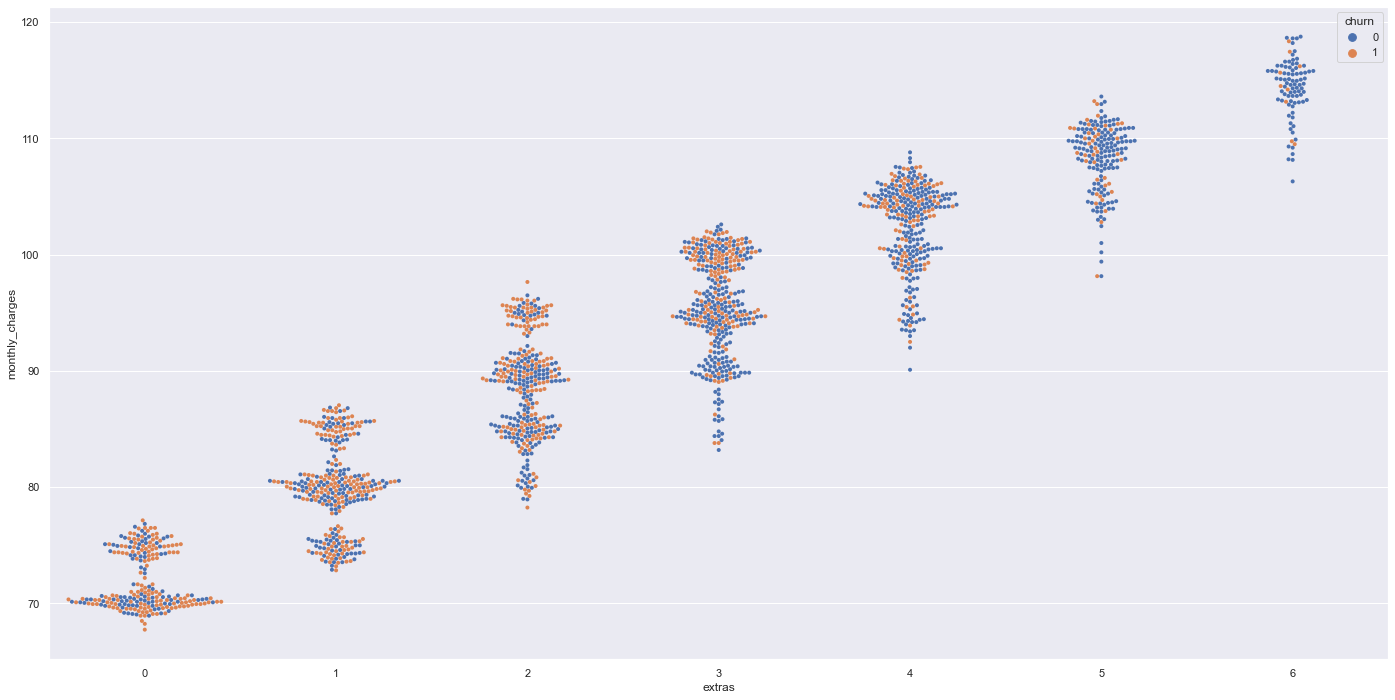

In [28]:
plt.figure(figsize=(24,12))
sns.swarmplot(data=train[train['Fiber optic'] == 1], y='monthly_charges', x='extras', hue='churn', size=4)
plt.show()

#### 6. Tenure seems to play a role early on. Possibly effected by other drivers
        Q6a. Does tenure have a relationship with churn?
        A6a. There is a relationship where low tenure leads to higher rates of churn.
        Qbb. Does it effect the other drivers?
        A6b. No

<AxesSubplot:xlabel='tenure', ylabel='Count'>

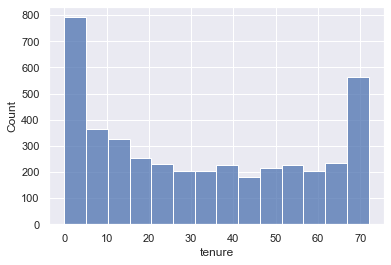

In [29]:
sns.histplot(data=train, x='tenure')

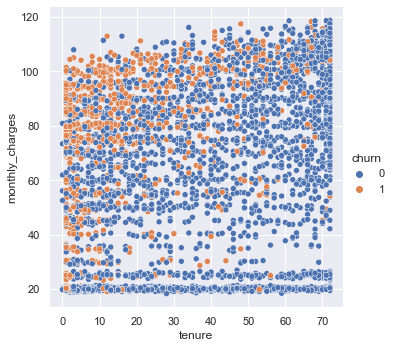

In [30]:
sns.relplot(data=train, x='tenure', y='monthly_charges', hue='churn')

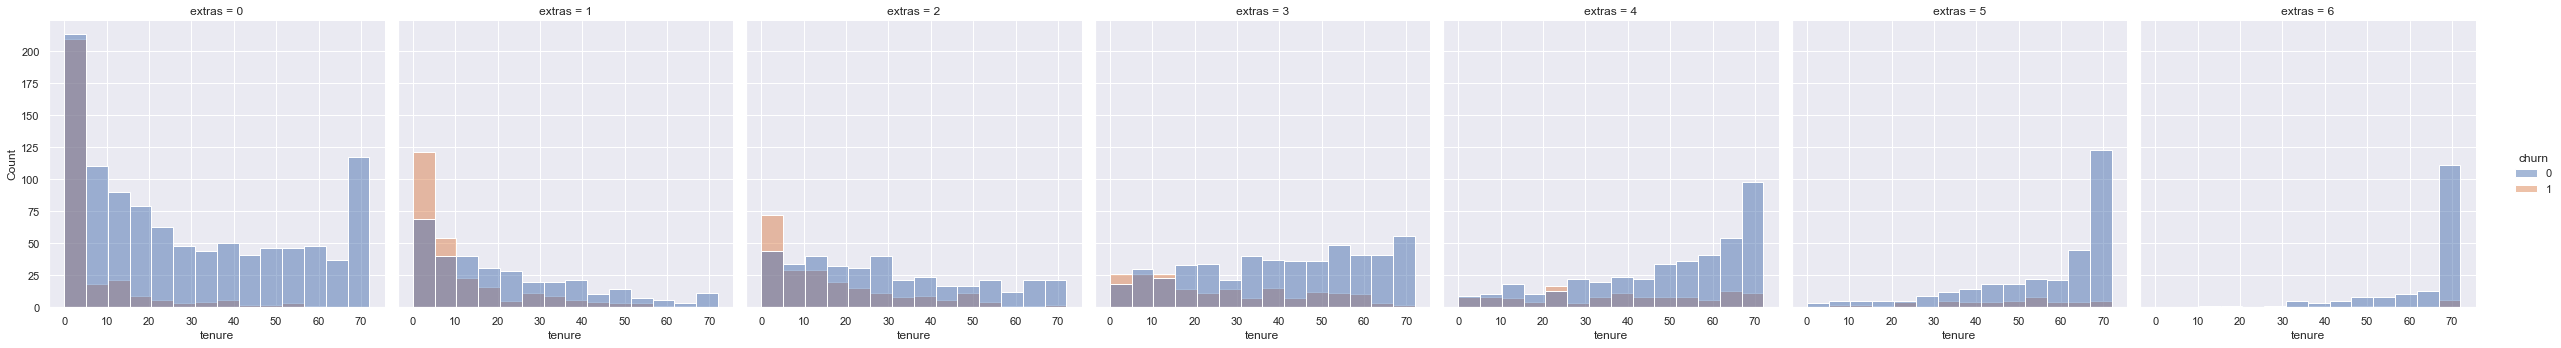

In [31]:
sns.displot(data=train, x='tenure', hue='churn', col='extras')

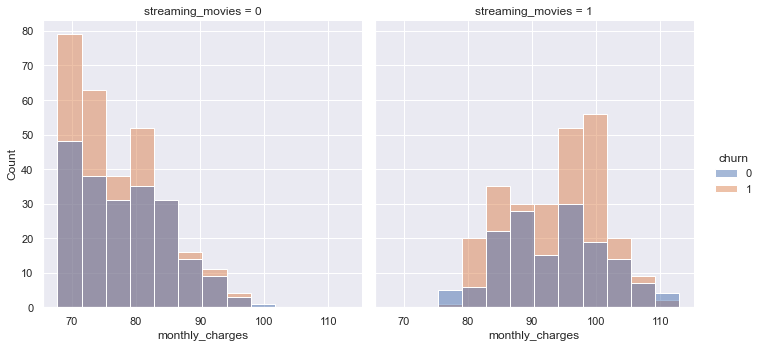

In [32]:
sns.displot(data=train[(train['Fiber optic'] == 1) & (train['tenure'] < 30)], x='monthly_charges', hue='churn', col='streaming_movies')

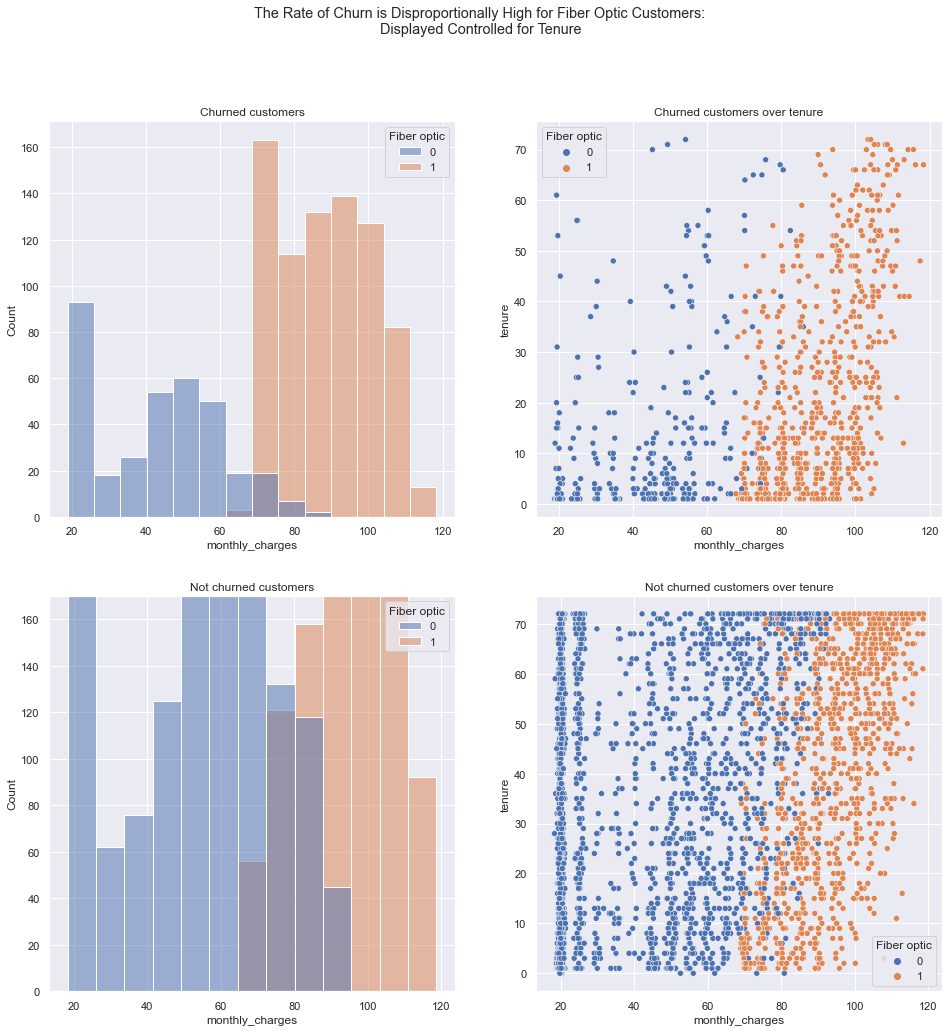

In [33]:
fig, axes = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('''The Rate of Churn is Disproportionally High for Fiber Optic Customers: 
Displayed Controlled for Tenure''')

# Churning customers, no matter where in tenure, are churning the most when they have fiber optic. 
axes[0,0].set_title('Churned customers')
axes[0,1].set_title('Churned customers over tenure')
axes[1,0].set_title('Not churned customers')
axes[1,1].set_title('Not churned customers over tenure')

sns.histplot(ax=axes[0,0], data=train[train.churn == 1], x='monthly_charges', hue='Fiber optic')
sns.scatterplot(ax=axes[0,1], data=train[(train.churn == 1)], y='tenure', x='monthly_charges', hue='Fiber optic')
sns.histplot(ax=axes[1,0], data=train[train.churn == 0], x='monthly_charges', hue='Fiber optic')
axes[1,0].set_ylim(0,170)
sns.scatterplot(ax=axes[1,1], data=train[(train.churn == 0)], y='tenure', x='monthly_charges', hue='Fiber optic')
plt.show()
# would look further into when customers (get fiber optic vs their churn date) vs (non-fiber optic vs churn date)

#### UPDATE ON FINDINGS:
1. There is a peak in monthly charges around 80
        Q1. Is a feature causing this cluster?
        A1: Fiber optic. Chart above STARTS around 70. DSL can go as low as the 20s
        
2. Having more extras, leads to less churn (logic follows they pay more per month OR there is a bundling deal)
        Q2. Does monthly cost go up with additional extras?
        A2. Yes, less churn possibly tied to better consumer experience.
        
3. Having a single line (without dependents or partner) leads to more churn
        Q3. Look into further
        
4. Having paperless billing leads to almost double the churn than not having paperless billing
        Q4. Specifically how much? Is there another factor tied to this causing it?
        A4. 74.7% of all customers have paperless billing
            19.8% of all customers churned with paperless billing
            25.2% of all churn had paperless billing
            
5. Having fiber optic leads to over double the churn than not having fiber optic
        Q5. What is causing more churn with fiber optic than DSL? DSL seems stable in churn rates.
        A5. 43.9% of all customers have fiber optic
            18.3% of all customers churned with fiber optic
            68.9% of all churn had fiber optic
            
6. Tenure seems to play a role early on. Possibly effected by other drivers
        Q6a. Does tenure have a relationship with churn?
        A6a. There is a relationship where low tenure leads to higher rates of churn.
        Qbb. Does it effect the other drivers?
        A6b. No

## 5. MODEL

Want to use recall --> Capture all churning customers and minimize false negatives

In [34]:
val['extras'] = val['online_security'] + val['online_backup']+val['device_protection']+val['tech_support']+ val['streaming_tv']+val['streaming_movies']
test['extras'] = test['online_security'] + test['online_backup']+test['device_protection']+test['tech_support']+ test['streaming_tv']+test['streaming_movies']

In [35]:
train_save = train
val_save = val
test_save = test

In [36]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic',
       'Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check', 'extras'],
      dtype='object')

In [37]:
drop_cols = [
             'online_security', 
             'online_backup', 
             'device_protection', 
             'tech_support', 
             'streaming_tv', 
             'streaming_movies', 
             'partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]
train = train.drop(columns=drop_cols)
val = val.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [38]:
'gender', 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic', 'extras'

('gender',
 'senior_citizen',
 'tenure',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'DSL',
 'Fiber optic',
 'extras')

In [39]:
train.columns

Index(['customer_id', 'senior_citizen', 'tenure', 'paperless_billing',
       'monthly_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic',
       'extras'],
      dtype='object')

In [40]:
X_train = train.drop(columns=['churn', 'customer_id'])
y_train = train.churn
X_val = val.drop(columns=['churn', 'customer_id'])
y_val = val.churn
X_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

In [41]:
X_train.columns

Index(['senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges',
       'contract_type', 'DSL', 'Fiber optic', 'extras'],
      dtype='object')

In [42]:
X_val.columns

Index(['senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges',
       'contract_type', 'DSL', 'Fiber optic', 'extras'],
      dtype='object')

#### Create Baseline

In [43]:
baseline = y_train.mode()
baseline

0    0
Name: churn, dtype: int64

In [44]:
baseline_accuracy = (y_train == 0).mean()
baseline_accuracy

0.7346745562130178

#### Decision Tree

In [45]:
model.binary_decisiontree_data(X_train, y_train)

,max_depth,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
tree 1,2,75.98%,61.46%,81.22%,18.78%,38.54%,54.17%,57.58%,1121,3104
tree 2,3,78.79%,37.56%,93.69%,6.31%,62.44%,68.23%,48.45%,1121,3104
tree 3,4,79.27%,49.96%,89.85%,10.15%,50.04%,64.0%,56.11%,1121,3104
tree 4,5,80.07%,54.15%,89.43%,10.57%,45.85%,64.92%,59.05%,1121,3104
tree 5,6,80.66%,53.61%,90.43%,9.57%,46.39%,66.93%,59.53%,1121,3104
tree 6,7,81.82%,60.04%,89.69%,10.31%,39.96%,67.77%,63.67%,1121,3104


Tree 5 with depth 6 isn't overfit and maximizes recall.

In [46]:
tree5 = DecisionTreeClassifier(max_depth=5)
tree5.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [47]:
tree5.score(X_train, y_train), tree5.score(X_val, y_val)

(0.8007100591715977, 0.7934705464868701)

In [48]:
met.recall_score(y_train, tree5.predict(X_train)), met.recall_score(y_val, tree5.predict(X_val))

(0.5414808206958073, 0.5213903743315508)

### Random Forest

In [49]:
model.binary_randomforest_data(X_train, y_train)

,max_depth,min_samples_leaf,accuracy,recall_TPR,specificity_TNR,FPR,FNR,percision,f1,support_pos,support_neg
forest 1,2,1,76.78%,18.29%,97.91%,2.09%,81.71%,75.93%,29.48%,1121,3104
forest 2,2,6,76.78%,18.29%,97.91%,2.09%,81.71%,75.93%,29.48%,1121,3104
forest 3,2,11,76.78%,18.29%,97.91%,2.09%,81.71%,75.93%,29.48%,1121,3104
forest 4,2,16,76.78%,18.29%,97.91%,2.09%,81.71%,75.93%,29.48%,1121,3104
forest 5,2,21,76.78%,18.2%,97.94%,2.06%,81.8%,76.12%,29.37%,1121,3104
forest 6,2,26,76.78%,18.29%,97.91%,2.09%,81.71%,75.93%,29.48%,1121,3104
forest 7,4,1,79.12%,38.54%,93.78%,6.22%,61.46%,69.12%,49.48%,1121,3104
forest 8,4,6,79.1%,38.54%,93.75%,6.25%,61.46%,69.01%,49.46%,1121,3104
forest 9,4,11,79.1%,38.09%,93.91%,6.09%,61.91%,69.32%,49.17%,1121,3104
forest 10,4,16,78.98%,37.73%,93.88%,6.12%,62.27%,69.0%,48.79%,1121,3104


Forest 23 - max depth = 7, min sample leaf = 3

In [50]:
forest23 = RandomForestClassifier(max_depth=7, min_samples_leaf=3)
forest23.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=3)

In [51]:
forest23.score(X_train, y_train), forest23.score(X_val, y_val)

(0.8170414201183432, 0.8034066713981547)

In [52]:
met.recall_score(y_train, forest23.predict(X_train)), met.recall_score(y_val, forest23.predict(X_val))

(0.5468331846565566, 0.5267379679144385)

### KNN

In [53]:
model.binary_KNN_data(X_train, y_train, 'uniform')

,neighbors,accuracy,recall_tpr,specificity_tnr,fpr,fnr,percision,f1,support_pos,support_neg
knn 1,1,99.08%,98.22%,99.39%,0.61%,1.78%,98.3%,98.26%,1121,3104
knn 2,2,86.86%,50.58%,99.97%,0.03%,49.42%,99.82%,67.14%,1121,3104
knn 3,3,86.58%,69.94%,92.59%,7.41%,30.06%,77.32%,73.44%,1121,3104
knn 4,4,84.21%,50.49%,96.39%,3.61%,49.51%,83.48%,62.92%,1121,3104
knn 5,5,84.02%,62.44%,91.82%,8.18%,37.56%,73.38%,67.47%,1121,3104
knn 6,6,82.93%,49.33%,95.07%,4.93%,50.67%,78.33%,60.54%,1121,3104
knn 7,7,82.96%,58.07%,91.95%,8.05%,41.93%,72.25%,64.39%,1121,3104
knn 8,8,82.27%,49.24%,94.2%,5.8%,50.76%,75.41%,59.58%,1121,3104
knn 9,9,82.37%,56.29%,91.78%,8.22%,43.71%,71.22%,62.88%,1121,3104
knn 10,10,81.73%,47.81%,93.98%,6.02%,52.19%,74.14%,58.13%,1121,3104


knn5 - 5 neighbors

In [54]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn5.fit(X_train, y_train)

KNeighborsClassifier()

In [55]:
knn5.score(X_train, y_train), knn5.score(X_val, y_val)

(0.8402366863905325, 0.7764371894960965)

In [56]:
met.recall_score(y_train, knn5.predict(X_train)), met.recall_score(y_val, knn5.predict(X_val))

(0.6244424620874219, 0.5240641711229946)

### Logistic Regression

In [57]:
models, odds = model.binary_logisticregression_data(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [58]:
models

,C,accuracy,recall_tpr,specificity_tnr,fpr,fnr,percision,f1,support_pos,support_neg
logit 1,0.01,78.98%,48.97%,89.82%,10.18%,51.03%,63.47%,55.29%,1121,3104
logit 2,0.1,78.91%,48.53%,89.88%,10.12%,51.47%,63.4%,54.98%,1121,3104
logit 3,1,78.93%,48.53%,89.92%,10.08%,51.47%,63.48%,55.01%,1121,3104
logit 4,10,78.86%,48.26%,89.92%,10.08%,51.74%,63.35%,54.78%,1121,3104
logit 5,100,78.82%,48.17%,89.88%,10.12%,51.83%,63.23%,54.68%,1121,3104
logit 6,1000,78.84%,48.26%,89.88%,10.12%,51.74%,63.27%,54.76%,1121,3104


In [59]:
odds

,senior_citizen,tenure,paperless_billing,monthly_charges,contract_type,DSL,Fiber optic,extras,C
logit 1,1.177823,0.966302,1.292170,1.029394,1.112983,1.051941,1.171245,0.871989,0.01
logit 2,1.355218,0.965746,1.534739,1.018918,1.103641,1.346137,2.107282,0.903405,0.1
logit 3,1.405546,0.966208,1.587322,1.015323,1.102415,1.633308,2.781502,0.922522,1
logit 4,1.331207,0.966437,1.602549,1.013283,1.101193,1.655163,3.137745,0.926933,10
logit 5,1.348848,0.966498,1.609115,1.014086,1.102496,1.634421,2.998648,0.924505,100
logit 6,1.373575,0.966396,1.643654,1.013786,1.098210,1.629419,2.974335,0.922879,1000


In [60]:
logit3 = LogisticRegression()
logit3.fit(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])

In [62]:
models = {}
for i in np.arange(0,1,.1):
    y_pred_train = (y_pred_proba_train.churned > i).astype(int)
    accuracy = met.accuracy_score(y_train, y_pred_train)
    recall = met.recall_score(y_train, y_pred_train)
    
    y_pred_val = (y_pred_proba_val.churned > i).astype(int)
    val_acc = met.accuracy_score(y_val, y_pred_val)
    val_recall = met.recall_score(y_val, y_pred_val)
    
    models[f'threshold {i}'] = [accuracy, recall, val_acc, val_recall]
    
pd.DataFrame(models, index = ['train_acc', 'train_recall', 'val_acc', 'val_recall']).T

,train_acc,train_recall,val_acc,val_recall
threshold 0.0,0.265325,1.000000,0.265436,1.000000
threshold 0.1,0.598580,0.943800,0.595458,0.927807
threshold 0.2,0.704852,0.837645,0.713982,0.863636
threshold 0.30000000000000004,0.752426,0.742194,0.765791,0.783422
threshold 0.4,0.778462,0.628011,0.787083,0.641711
threshold 0.5,0.789349,0.485281,0.797729,0.510695
threshold 0.6000000000000001,0.787219,0.350580,0.792051,0.377005
threshold 0.7000000000000001,0.760237,0.128457,0.765082,0.141711
threshold 0.8,0.734675,0.000000,0.734564,0.000000
threshold 0.9,0.734675,0.000000,0.734564,0.000000


In [63]:
y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])
y_pred_train = (y_pred_proba_train.churned > 0.3).astype(int)
logit_accuracy = met.accuracy_score(y_train, y_pred_train)
logit_recall = met.recall_score(y_train, y_pred_train)

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])
y_pred_val = (y_pred_proba_val.churned > 0.3).astype(int)
val_acc = met.accuracy_score(y_val, y_pred_val)
val_recall = met.recall_score(y_val, y_pred_val)

Threshold of 0.3 is producing the best accuracy and recall consistency while maxing out recall. 

### MODEL SUMMARY:

 - Findings while choosing different features to test showed the best hyperparameters for each model were consistent
 - Each set of features optimized a different model type
 - Top 3 models numbered below

USING COLUMNS - 'gender', 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic', 'extras'



| Model | Train Accuracy | Validate Accuracy | Train Recall | Validate Recall | Ranking |
| ---- | ---- | ---- | ---- | ---- | ---- |
| Baseline | 73.47% |  |  |  |  |
| Tree5 | 80.14% | 79.28% | 54.42% | 52.14%|  |
| Forest23 | 82.37% | 80.20% | 54.95% | 50.80% |  |
| KNN5 | 83.31% | 77.43% | 59.59% | 48.40% |  |
| Logit3 | 73.70% | 73.53% | 78.23% | 79.14%  | 1 |




Baseline: 
    Accuracy: 73.47%

Tree5 with depth of 6:
    Train:
        Accuracy: 80.14%
        Recall: 54.42%
    Validate:
        Accuracy: 79.28%
        Recall: 52.14%

Forest23:
    Train:
        Accuracy: 82.37%
        Recall: 54.95%
    Validate:
        Accuracy: 80.20%
        Recall: 50.80%
    
KNN5
    Train:
        Accuracy: 83.31%
        Recall : 59.59%
    Validate:
        Accuracy: 77.43%
        Recall : 48.40%
    
Logit3:
    Train:
        Accuracy: 73.70%
        Recall : 78.23%
    Validate:
        Accuracy: 73.53%
        Recall : 79.14% <-- #1

---------------------------------------------------------------------------------------------------

USING COLUMNS - 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'churn', 'contract_type', 'Fiber optic'

| Model | Train Accuracy | Validate Accuracy | Train Recall | Validate Recall | Ranking |
| ---- | ---- | ---- | ---- | ---- | ---- |
| Baseline | 73.47% |  |  |  |  |
| Tree5 | 80.00% | 79.21% | 54.42% | 52.14%|  |
| Forest23 | 81.75% | 80.34% | 54.59% | 52.41% | 2 |
| KNN5 | 83.88% | 77.29% | 62.71% | 50.53% |  |
| Logit3 | 75.15% | 76.22% | 74.49% | 77.81%  |  |

Baseline: 
    Accuracy: 73.47%

Tree5 with depth of 6:
    Train:
        Accuracy: 80.00%
        Recall: 54.42%
    Validate:
        Accuracy: 79.21%
        Recall: 52.14%

Forest23:
    Train:
        Accuracy: 81.75%
        Recall: 54.59%
    Validate:
        Accuracy: 80.34%
        Recall: 52.41%  <--- #2 (less likely overfit)
    
KNN5
    Train:
        Accuracy: 83.88%
        Recall : 62.71%
    Validate:
        Accuracy: 77.29%
        Recall : 50.53%
    
Logit3:
    Train:
        Accuracy: 75.15%
        Recall : 74.49%
    Validate:
        Accuracy: 76.22%
        Recall : 77.81%

-----

USING COLUMNS - 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic', 'extras'

| Model | Train Accuracy | Validate Accuracy | Train Recall | Validate Recall | Ranking |
| ---- | ---- | ---- | ---- | ---- | ---- |
| Baseline | 73.47% |  |  |  |  |
| Tree5 | 80.07% | 79.35% | 54.15% | 52.14%|
| Forest23 | 81.70% | 80.55% | 54.15% | 51.07% |  |
| KNN5 | 84.02% | 77.64% | 62.44% | 52.41% | 3|
| Logit3 | 75.24% | 76.58% | 74.22% | 78.34%  |  |

Baseline: 
    Accuracy: 73.47%

Tree5 with depth of 6:
    Train:
        Accuracy: 80.07%
        Recall: 54.15%
    Validate:
        Accuracy: 79.35%
        Recall: 52.14%

Forest23:
    Train:
        Accuracy: 81.70%
        Recall: 54.15%
    Validate:
        Accuracy: 80.55%
        Recall: 51.07%
    
KNN5
    Train:
        Accuracy: 84.02%
        Recall : 62.44%
    Validate:
        Accuracy: 77.64%
        Recall : 52.41% <--- #3 (more likely overfit)
    
Logit3:
    Train:
        Accuracy: 75.24%
        Recall : 74.22%
    Validate:
        Accuracy: 76.58%
        Recall : 78.34%

In [64]:
# print(f'''Baseline: 
#     Accuracy: {baseline_accuracy:.2%}

# Tree5 with depth of 6:
#     Train:
#         Accuracy: {tree5.score(X_train, y_train):.2%}
#         Recall: {met.recall_score(y_train, tree5.predict(X_train)):.2%}
#     Validate:
#         Accuracy: {tree5.score(X_val, y_val):.2%}
#         Recall: {met.recall_score(y_val, tree5.predict(X_val)):.2%}

# Forest23:
#     Train:
#         Accuracy: {forest23.score(X_train, y_train):.2%}
#         Recall: {met.recall_score(y_train, forest23.predict(X_train)):.2%}
#     Validate:
#         Accuracy: {forest23.score(X_val, y_val):.2%}
#         Recall: {met.recall_score(y_val, forest23.predict(X_val)):.2%}
    
# KNN5
#     Train:
#         Accuracy: {knn5.score(X_train, y_train):.2%}
#         Recall : {met.recall_score(y_train, knn5.predict(X_train)):.2%}
#     Validate:
#         Accuracy: {knn5.score(X_val, y_val):.2%}
#         Recall : {met.recall_score(y_val, knn5.predict(X_val)):.2%}
    
# Logit3:
#     Train:
#         Accuracy: {logit_accuracy:.2%}
#         Recall : {logit_recall:.2%}
#     Validate:
#         Accuracy: {val_acc:.2%}
#         Recall : {val_recall:.2%}
#     ''')

### Best Models

In [67]:
train1.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic',
       'Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check', 'extras'],
      dtype='object')

In [68]:
# reset split to test top 3 side by side
train1 = train_save
val1 = val_save
test1 = test_save
train2 = train_save
val2 = val_save
test2 = test_save
train3 = train_save
val3 = val_save
test3 = test_save

In [69]:
train1.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic',
       'Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check', 'extras'],
      dtype='object')

In [70]:
# logit3 with 'gender', 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic', 'extras'

In [71]:
drop_cols = [
             'online_security', 
             'online_backup', 
             'device_protection', 
             'tech_support', 
             'streaming_tv', 
             'streaming_movies', 
             'partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]
train1 = train.drop(columns=drop_cols)
val1 = val.drop(columns=drop_cols)
test1 = test.drop(columns=drop_cols)

X_train = train1.drop(columns=['churn', 'customer_id'])
y_train = train1.churn
X_val = val1.drop(columns=['churn', 'customer_id'])
y_val = val1.churn
X_test = test1.drop(columns=['churn', 'customer_id'])
y_test = test1.churn

KeyError: "['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check', 'total_charges', 'gender'] not found in axis"

In [ ]:
logit3 = LogisticRegression()
logit3.fit(X_train, y_train)

y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])
y_pred_train = (y_pred_proba_train.churned > 0.3).astype(int)
logit_accuracy = met.accuracy_score(y_train, y_pred_train)
logit_recall = met.recall_score(y_train, y_pred_train)

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])
y_pred_val = (y_pred_proba_val.churned > 0.3).astype(int)
val_acc = met.accuracy_score(y_val, y_pred_val)
val_recall = met.recall_score(y_val, y_pred_val)

first = pd.DataFrame({'logit3' : {'acc_train': logit_accuracy,
                         'acc_val' : val_acc,
                         'recall_train': logit_recall,
                         'recall_val': val_recall,}
                     }).T

In [41]:
first

,acc_train,acc_val,recall_train,recall_val
logit3,0.737041,0.735273,0.782337,0.791444


In [42]:
# forest23 with 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'churn', 'contract_type', 'Fiber optic'

In [43]:
drop_cols = [
             'online_security', 
             'online_backup', 
             'device_protection', 
             'tech_support', 
             'streaming_tv', 
             'streaming_movies', 
             'partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]
train2 = train.drop(columns=drop_cols)
val2 = val.drop(columns=drop_cols)
test2 = test.drop(columns=drop_cols)

X_train = train2.drop(columns=['churn', 'customer_id'])
y_train = train2.churn
X_val = val2.drop(columns=['churn', 'customer_id'])
y_val = val2.churn
X_test = test2.drop(columns=['churn', 'customer_id'])
y_test = test2.churn

In [44]:
forest23 = RandomForestClassifier(max_depth=7, min_samples_leaf=3)
forest23.fit(X_train, y_train)


second = pd.DataFrame({'forest23' : {'acc_train': forest23.score(X_train, y_train),
                         'acc_val' : forest23.score(X_val, y_val),
                         'recall_train': met.recall_score(y_train, forest23.predict(X_train)),
                         'recall_val': met.recall_score(y_val, forest23.predict(X_val))}
             }).T



In [45]:
# knn5 with 'senior_citizen', 'tenure', 'paperless_billing', 'monthly_charges', 'churn', 'contract_type', 'DSL', 'Fiber optic', 'extras'

In [46]:
drop_cols = [
             'online_security', 
             'online_backup', 
             'device_protection', 
             'tech_support', 
             'streaming_tv', 
             'streaming_movies', 
             'partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]
train3 = train.drop(columns=drop_cols)
val3 = val.drop(columns=drop_cols)
test3 = test.drop(columns=drop_cols)

X_train = train3.drop(columns=['churn', 'customer_id'])
y_train = train3.churn
X_val = val3.drop(columns=['churn', 'customer_id'])
y_val = val3.churn
X_test = test3.drop(columns=['churn', 'customer_id'])
y_test = test3.churn

In [47]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn5.fit(X_train, y_train)

third = pd.DataFrame({'knn5' : {'acc_train': knn5.score(X_train, y_train),
                         'acc_val' : knn5.score(X_val, y_val),
                         'recall_train': met.recall_score(y_train, knn5.predict(X_train)),
                         'recall_val': met.recall_score(y_val, knn5.predict(X_val))}
             }).T

In [48]:
pd.concat([first, second, third],axis=0)

,acc_train,acc_val,recall_train,recall_val
logit3,0.737041,0.735273,0.782337,0.791444
forest23,0.820118,0.801278,0.547725,0.521390
knn5,0.840237,0.776437,0.624442,0.524064


### Run Test on Best Model

In [49]:
drop_cols = [
             'online_security', 
             'online_backup', 
             'device_protection', 
             'tech_support', 
             'streaming_tv', 
             'streaming_movies', 
             'partner', 
             'dependents', 
             'phone_service', 
             'multiple_lines',
             'Bank transfer (automatic)',
             'Credit card (automatic)',
             'Electronic check',
             'Mailed check',
             # 'contract_type',
             # 'total_charges',
             # 'DSL',
             # 'monthly_charges',
             # 'paperless_billing',
             # 'gender',
             # 'senior_citizen'
             # 'tenure'
             # 'extras'
]
train1 = train.drop(columns=drop_cols)
val1 = val.drop(columns=drop_cols)
test1 = test.drop(columns=drop_cols)

X_train = train1.drop(columns=['churn', 'customer_id'])
y_train = train1.churn
X_val = val1.drop(columns=['churn', 'customer_id'])
y_val = val1.churn
X_test = test1.drop(columns=['churn', 'customer_id'])
y_test = test1.churn

In [50]:
logit3 = LogisticRegression()
logit3.fit(X_train, y_train)

y_pred_proba_train = logit3.predict_proba(X_train)
y_pred_proba_train = pd.DataFrame(y_pred_proba_train, columns = ['stayed', 'churned'])
y_pred_train = (y_pred_proba_train.churned > 0.3).astype(int)
logit_accuracy = met.accuracy_score(y_train, y_pred_train)
logit_recall = met.recall_score(y_train, y_pred_train)

y_pred_proba_val = logit3.predict_proba(X_val)
y_pred_proba_val = pd.DataFrame(y_pred_proba_val, columns = ['stayed', 'churned'])
y_pred_val = (y_pred_proba_val.churned > 0.3).astype(int)
val_acc = met.accuracy_score(y_val, y_pred_val)
val_recall = met.recall_score(y_val, y_pred_val)

y_pred_proba_test = logit3.predict_proba(X_test)
y_pred_proba_test = pd.DataFrame(y_pred_proba_test, columns = ['stayed', 'churned'])
y_pred_test = (y_pred_proba_test.churned > 0.3).astype(int)
test_acc = met.accuracy_score(y_test, y_pred_test)
test_recall = met.recall_score(y_test, y_pred_test)

first = pd.DataFrame({'logit3' : {'acc_train': logit_accuracy,
                         'acc_val' : val_acc,
                         'acc_test' : test_acc,
                         'recall_train': logit_recall,
                         'recall_val': val_recall,
                         'recall_test': test_recall}}).T


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
first

,acc_test,acc_train,acc_val,recall_test,recall_train,recall_val
logit3,0.738112,0.737041,0.735273,0.802139,0.782337,0.791444


### Create Predictions csv

In [56]:
predict_stay = np.array(y_pred_proba_test.stayed)
predict = np.array(y_pred_proba_test.churned)
churn_or_not = np.where(y_pred_test == 1, 'Churn', 'Stay')
customers = np.array(test1.customer_id)

#pd.concat([customers, predictions, churn_or_not], axis=1)

In [57]:
predict_stay.shape, predict.shape, churn_or_not.shape, customers.shape

((1409,), (1409,), (1409,), (1409,))

In [59]:
predictions = pd.DataFrame([customers, predict_stay, predict, churn_or_not]).T

In [60]:
predictions.columns = ['customer', 'probability_of_staying', 'probability_of_churn', 'prediction']
predictions

,customer,probability_of_staying,probability_of_churn,prediction
0,4531-AUZNK,0.801914,0.198086,Stay
1,2296-DKZFP,0.985832,0.014168,Stay
2,9692-TUSXH,0.395611,0.604389,Churn
3,5129-JLPIS,0.528324,0.471676,Churn
4,1273-MTETI,0.190124,0.809876,Churn
...,...,...,...,...
1404,1597-FZREH,0.622568,0.377432,Churn
1405,9117-SHLZX,0.543472,0.456528,Churn
1406,8441-SHIPE,0.991655,0.008345,Stay
1407,3511-BFTJW,0.997483,0.002517,Stay


In [61]:
predictions.to_csv('predictions.csv',index=False)